"We certify that the code and data in this assignment were generated independently, using only
the tools and resources defined in the course and that we did not receive any external help,
coaching or contributions during the production of this work."



In [ ]:
# install display helpers
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip install pyvirtualdisplay pygame
!pip install -U gym
!pip install gym-notebook-wrapper
!pip3 install box2d-py
!pip3 install gym[Box_2D]
from pyvirtualdisplay import Display
    
# Start virtual display
_ = Display(visible=0, size=(500, 500))
_.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (582 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package 

In [24]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple


In [25]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('States ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

States  (8,)
Number of actions:  4


/usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


In [26]:
class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed):

        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [27]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
e = 1e-3                # for soft update of target parameters
LR = 5e-4               # learning rate 

In [32]:
class Agent():
  

    def __init__(self, state_size, action_size, seed):
      
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

     
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
       
        self.t_step = 0

    def getValidActions(self):
        actionAvailable = self.possibleAction(self.agent_pos)
        stateAvailable = self.getAllFinalPosition(actionAvailable)
        finalaction, finalstate = self.getStateActionPair(actionAvailable, stateAvailable)
        return finalaction
    
    def step(self, state, action, reward, next_state, done):
        
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
           
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def bestStateFromQValue(self,possibleActions, possibleStates):
        currentMax = None
        fstate = None
        faction = None
        qValues = None

        for action,state in zip(possibleActions, possibleStates):
            if state[0] == self.rows-1 or state[1] == self.cols-1:
                return action, state,0, 0 

            elif currentMax == None:
                currentMax= self.qTable[tuple(self.agent_pos)][action]
                fstate = state
                faction = action
                qValues = self.qTable[tuple(self.agent_pos)]

            elif currentMax != None:
                max1 = self.qTable[tuple(self.agent_pos)][action]
                if max1 > currentMax:
                    currentMax = max1
                    fstate = state
                    faction = action
                    qValues = self.qTable[tuple(self.agent_pos)]

        return faction, fstate, currentMax, qValues

    def act(self, state, episode=0.):
       
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > episode:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
       
        states, actions, rewards, next_states, dones = experiences
        batch=64
        
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        sample=BUFFER_SIZE
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

  
        self.soft_update(self.qnetwork_local, self.qnetwork_target, e)                     

    def soft_update(self, local_model, target_model, e):

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(e*local_param.data + (1.0-e)*target_param.data)

In [33]:
class ReplayBuffer:
   

    def __init__(self, action_size, buffer_size, batch_size, seed):
   
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([i.state for i in experiences if i is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([i.action for i in experiences if i is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([i.reward for i in experiences if i is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([i.next_state for i in experiences if i is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([i.done for i in experiences if i is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    
    rewards = []                       
    rewards_window = deque(maxlen=100)  
    eps = eps_start                    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        rewards_window.append(score)       
        rewards.append(score)              
        eps = max(eps_end, eps_decay*eps) 
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(rewards_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(rewards_window)))
        if np.mean(rewards_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(rewards_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return rewards

agent = Agent(state_size=8, action_size=4, seed=0)
rewards = dqn()

Episode 100	Average Score: -165.71
Episode 200	Average Score: -116.90
Episode 300	Average Score: -95.97
Episode 400	Average Score: -34.64
Episode 500	Average Score: 15.73
Episode 600	Average Score: 118.59
Episode 700	Average Score: 179.72
Episode 800	Average Score: 174.29
Episode 900	Average Score: 192.79
Episode 1000	Average Score: 194.69
Episode 1058	Average Score: 200.87
Environment solved in 958 episodes!	Average Score: 200.87


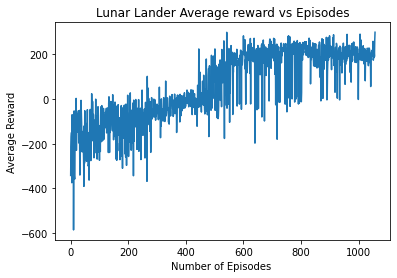

In [36]:
fig = plt.figure()
plt.plot(np.arange(len(rewards)), rewards)
plt.ylabel('Average Reward')
plt.xlabel('Number of Episodes ')
plt.title("Lunar Lander Average reward vs Episodes")
plt.show()